## Importing Libraries

In [622]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, TargetEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer

## Importing the dataset

In [623]:
dataset = pd.read_csv("./dataset/dairy_dataset.csv")
dataset.head()

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,Total Value,Shelf Life (days),Storage Condition,Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,Telangana,310.84,96,Medium,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,19064.1280,25,Frozen,2021-12-27,2022-01-21,7,82.24,575.68,Madhya Pradesh,Wholesale,215,19.55,64.03
1,Uttar Pradesh,19.19,44,Large,2021-12-01,1,Milk,Amul,687.48,42.61,29293.5228,22,Tetra Pack,2021-10-03,2021-10-25,558,39.24,21895.92,Kerala,Wholesale,129,43.17,181.10
2,Tamil Nadu,581.69,24,Medium,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,18377.0200,30,Refrigerated,2022-01-14,2022-02-13,256,33.81,8655.36,Madhya Pradesh,Online,247,15.10,140.83
3,Telangana,908.00,89,Small,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,21835.5072,72,Frozen,2019-05-15,2019-07-26,601,28.92,17380.92,Rajasthan,Online,222,74.50,57.68
4,Maharashtra,861.95,21,Medium,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,12390.5145,11,Refrigerated,2020-10-17,2020-10-28,145,83.07,12045.15,Jharkhand,Retail,2,76.02,33.40


# EDA + Descriptive Statistics

In [624]:
dataset.dtypes

Location                                object
Total Land Area (acres)                float64
Number of Cows                           int64
Farm Size                               object
Date                                    object
Product ID                               int64
Product Name                            object
Brand                                   object
Quantity (liters/kg)                   float64
Price per Unit                         float64
Total Value                            float64
Shelf Life (days)                        int64
Storage Condition                       object
Production Date                         object
Expiration Date                         object
Quantity Sold (liters/kg)                int64
Price per Unit (sold)                  float64
Approx. Total Revenue(INR)             float64
Customer Location                       object
Sales Channel                           object
Quantity in Stock (liters/kg)            int64
Minimum Stock

In [625]:
dataset.isnull().sum()

Location                               0
Total Land Area (acres)                0
Number of Cows                         0
Farm Size                              0
Date                                   0
Product ID                             0
Product Name                           0
Brand                                  0
Quantity (liters/kg)                   0
Price per Unit                         0
Total Value                            0
Shelf Life (days)                      0
Storage Condition                      0
Production Date                        0
Expiration Date                        0
Quantity Sold (liters/kg)              0
Price per Unit (sold)                  0
Approx. Total Revenue(INR)             0
Customer Location                      0
Sales Channel                          0
Quantity in Stock (liters/kg)          0
Minimum Stock Threshold (liters/kg)    0
Reorder Quantity (liters/kg)           0
dtype: int64

There's no null data in the dataset.

### Categorical attributes

In [626]:
dataset.describe()

,Total Land Area (acres),Number of Cows,Product ID,Quantity (liters/kg),Price per Unit,Total Value,Shelf Life (days),Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
count,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.00000,4325.000000,4325.000000,4325.000000,4325.000000
mean,503.483073,54.963699,5.509595,500.652657,54.785938,27357.845411,29.127630,248.095029,54.77914,13580.265401,252.068671,55.826143,109.107820
std,285.935061,26.111487,2.842979,288.975915,26.002815,21621.051594,30.272114,217.024182,26.19279,14617.009122,223.620870,26.301450,51.501035
min,10.170000,10.000000,1.000000,1.170000,10.030000,42.516500,1.000000,1.000000,5.21000,12.540000,0.000000,10.020000,20.020000
25%,252.950000,32.000000,3.000000,254.170000,32.460000,9946.814500,10.000000,69.000000,32.64000,2916.650000,66.000000,32.910000,64.280000
50%,509.170000,55.000000,6.000000,497.550000,54.400000,21869.652900,22.000000,189.000000,54.14000,8394.540000,191.000000,56.460000,108.340000
75%,751.250000,77.000000,8.000000,749.780000,77.460000,40954.441000,30.000000,374.000000,77.46000,19504.550000,387.000000,79.010000,153.390000
max,999.530000,100.000000,10.000000,999.930000,99.990000,99036.369600,150.000000,960.000000,104.51000,89108.900000,976.000000,99.990000,199.950000


In [627]:
cat_f = dataset.select_dtypes("object")
cat_f.columns

Index(['Location', 'Farm Size', 'Date', 'Product Name', 'Brand',
       'Storage Condition', 'Production Date', 'Expiration Date',
       'Customer Location', 'Sales Channel'],
      dtype='object')

In [628]:
cat_f.describe()

,Location,Farm Size,Date,Product Name,Brand,Storage Condition,Production Date,Expiration Date,Customer Location,Sales Channel
count,4325,4325,4325,4325,4325,4325,4325,4325,4325,4325
unique,15,3,1278,10,11,5,1405,1441,15,3
top,Delhi,Large,2021-01-28,Curd,Amul,Refrigerated,2022-09-06,2022-02-01,Delhi,Retail
freq,525,1462,11,479,1053,2459,9,9,499,1478


In [629]:
cat_f.count()

Location             4325
Farm Size            4325
Date                 4325
Product Name         4325
Brand                4325
Storage Condition    4325
Production Date      4325
Expiration Date      4325
Customer Location    4325
Sales Channel        4325
dtype: int64

In [630]:
for col in cat_f:
    print(col, len(cat_f[col].unique()))

Location 15
Farm Size 3
Date 1278
Product Name 10
Brand 11
Storage Condition 5
Production Date 1405
Expiration Date 1441
Customer Location 15
Sales Channel 3


Date, Production Date and Expiration Date has a lot of unique values so we have to drop them.

In [631]:
dataset=dataset.drop(['Date', 'Production Date', 'Expiration Date'], axis=1)

### Numerical attributes

In [632]:
num_f = dataset.select_dtypes("number")
num_f.columns

Index(['Total Land Area (acres)', 'Number of Cows', 'Product ID',
       'Quantity (liters/kg)', 'Price per Unit', 'Total Value',
       'Shelf Life (days)', 'Quantity Sold (liters/kg)',
       'Price per Unit (sold)', 'Approx. Total Revenue(INR)',
       'Quantity in Stock (liters/kg)', 'Minimum Stock Threshold (liters/kg)',
       'Reorder Quantity (liters/kg)'],
      dtype='object')

In [633]:
fig = make_subplots(rows=4, cols=4)
for i, column in enumerate(num_f.columns):
    row = i // 4 + 1
    col = i % 4 + 1
    trace = go.Histogram(x=num_f[column], name=column)
    fig.add_trace(trace, row=row, col=col)
fig.show()

### Outliers

In [634]:
fig = make_subplots(rows=7, cols=2, horizontal_spacing=0.4)
for i, column in enumerate(num_f.columns):
    row = i // 2 + 1
    col = i % 2 + 1
    trace = go.Box(x=num_f[column], name=column)
    fig.add_trace(trace, row=row, col=col)
fig.show()

From the result, we can see that Quantity Sold and Shelf Life contains a lot of outliers. But for the purpose of demonstrating Robust Scaling, we're not removing the outliers.

In [635]:
def calc_iqr(df, attr):
    q3 = df[attr].quantile(0.75)
    q1 = df[attr].quantile(0.25)
    return q1, q3, q3 - q1

for col in num_f:
    q1, q3, iqr = calc_iqr(num_f, col)
    serie = num_f[col]
    outliers = serie[(serie < q1 - 1.5 * iqr) | (serie > q3 + 1.5 * iqr)]
    print(f"Outliers in column {col}: {outliers.size/dataset.shape[0] * 100} %")


Outliers in column Total Land Area (acres): 0.0 %
Outliers in column Number of Cows: 0.0 %
Outliers in column Product ID: 0.0 %
Outliers in column Quantity (liters/kg): 0.0 %
Outliers in column Price per Unit: 0.0 %
Outliers in column Total Value: 0.8554913294797687 %
Outliers in column Shelf Life (days): 13.364161849710982 %
Outliers in column Quantity Sold (liters/kg): 1.6416184971098264 %
Outliers in column Price per Unit (sold): 0.0 %
Outliers in column Approx. Total Revenue(INR): 5.202312138728324 %
Outliers in column Quantity in Stock (liters/kg): 0.9479768786127168 %
Outliers in column Minimum Stock Threshold (liters/kg): 0.0 %
Outliers in column Reorder Quantity (liters/kg): 0.0 %


There's not a lot of outliers.

## Sunburst Chart

In [636]:
product_by_brand = cat_f.groupby(["Product Name", "Brand"]).size().reset_index(name="Count")
fig2 = px.sunburst(product_by_brand,
                    path=["Brand", "Product Name"],
                    values="Count",
                    title="Sunburst charts of products by brand"
                    )
fig2.show()

From here, we can see the advantages of a sunburst chart. We can tell which brand make which product in one chart quite intuitively. As opposed to the alternative.

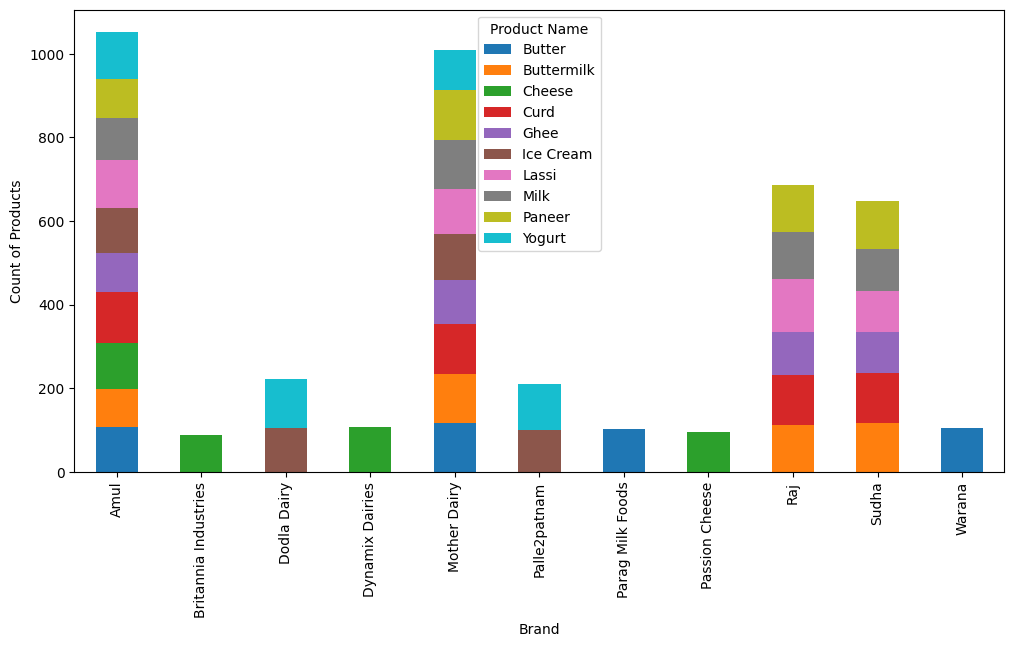

In [637]:
product_by_brand.pivot(index="Brand",
                       columns="Product Name",
                       values="Count").plot(kind="bar",
                                            stacked=True,
                                            figsize=(12, 6))
plt.xlabel("Brand")
plt.ylabel("Count of Products")
plt.legend(title="Product Name")

In [638]:
product_by_size_loc = cat_f.groupby(["Location", "Farm Size", "Product Name"]).size().reset_index(name="Count")
fig1 = px.sunburst(product_by_size_loc,
                    path=["Location", "Farm Size", "Product Name"],
                    values="Count",
                    title="Sunburst charts of products by location and farm size"
                    )
fig1.show()

For this chart, it'd be impossible to plot in all of these attributes in one traditional bar/pie chart. Therefore, using sunburst chart is the most optimal in this scenario.

## Correlation matrix

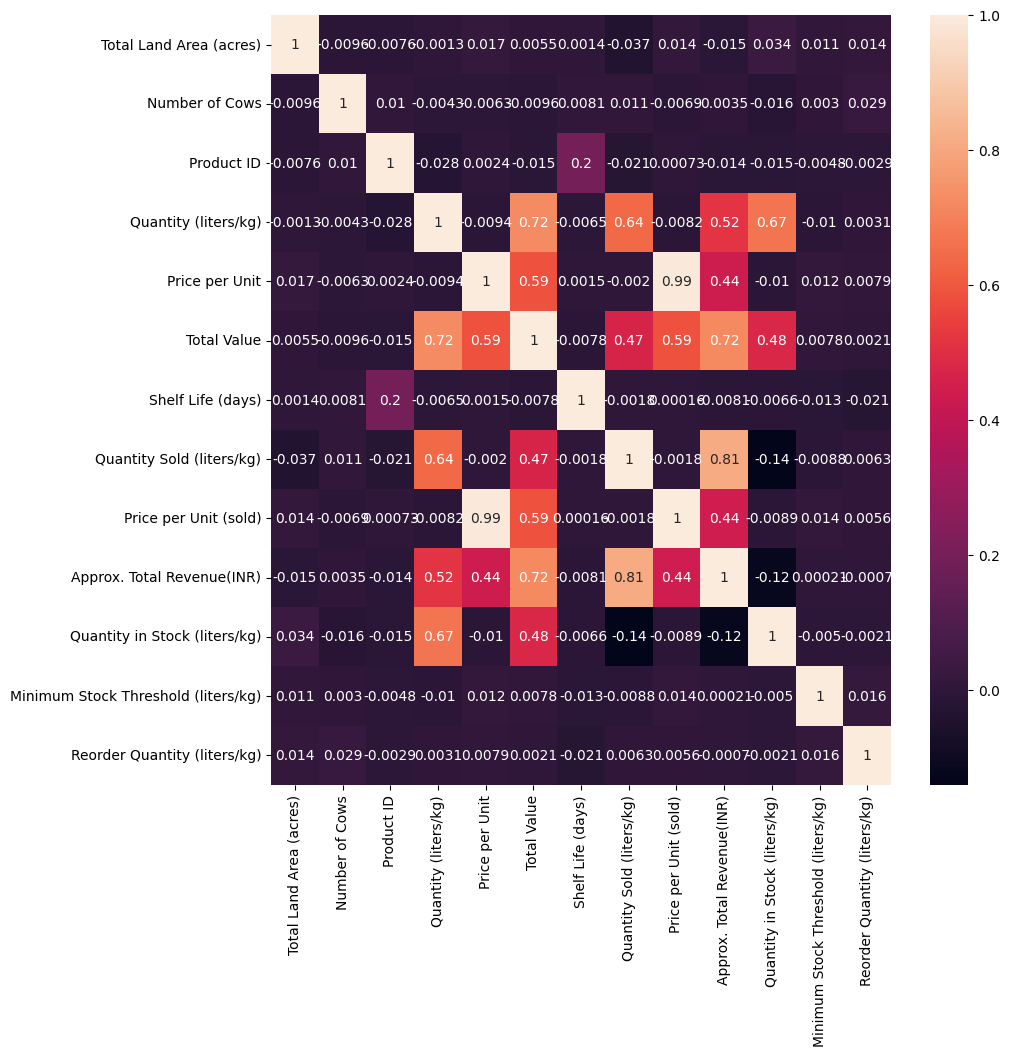

In [639]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(num_f.corr(), annot=True)
plt.show()

In [640]:
fig = make_subplots(rows=7, cols=2, horizontal_spacing=0.4)
for i, column in enumerate(num_f.columns):
    row = i // 2 + 1
    col = i % 2 + 1
    trace = go.Scatter(x=num_f[column], y=num_f["Price per Unit"], name=column, mode="markers")
    fig.add_trace(trace, row=row, col=col)
fig.update_layout(width=1000, height=1200)
fig.show()

From the scatter plot and the correlation matrix, we will predict price per unit from brand, product name, quantity sold, quantity in stock, Approx. total revenue, and Shelf Life because these are the numerical attributes with outliers. The scatter plot show us that there are not a lot of features that have a linear relationship with our target variable, so we will use KNN.

# Data Pre-processing

We'll showcase RobustScaler vs StandardScaler

## Convert Categorical data to numerical

We'll encode using target encoding to avoid the "curse of dimensionality".

In [641]:
te = TargetEncoder()
df = dataset.copy()
y = df["Price per Unit"]
ct = ColumnTransformer(transformers=[("", te, ["Brand",
                                                "Product Name"])],
                        verbose_feature_names_out=False,
                        remainder="passthrough")
x = df[["Brand",
        "Product Name",
        "Quantity Sold (liters/kg)",
        "Quantity in Stock (liters/kg)",
        "Approx. Total Revenue(INR)"]]

t_data = ct.fit_transform(x, y)
t_data_columns = ct.get_feature_names_out()
t_df = pd.DataFrame(t_data, columns=t_data_columns)
t_df.head()

,Brand,Product Name,Quantity Sold (liters/kg),Quantity in Stock (liters/kg),Approx. Total Revenue(INR)
0,53.456612,51.408884,7.0,215.0,575.68
1,54.040671,53.793917,558.0,129.0,21895.92
2,55.564432,54.527482,256.0,247.0,8655.36
3,51.149546,53.920365,601.0,222.0,17380.92
4,54.129899,55.728912,145.0,2.0,12045.15


In [642]:
y = df["Total Value"]
x = t_df[["Brand", "Product Name", "Quantity Sold (liters/kg)", "Quantity in Stock (liters/kg)", "Approx. Total Revenue(INR)"]]

## Split train-test

We'll split train : test = 0.8 : 0.2

In [643]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=69420)

In [644]:
print(x_train, x_test, y_train, y_test)

          Brand  ...  Approx. Total Revenue(INR)
2139  55.269214  ...                    31171.72
398   54.328802  ...                      165.72
280   55.294719  ...                     2624.93
4172  54.475690  ...                     6257.30
1457  55.180384  ...                    19636.96
...         ...  ...                         ...
4217  54.261793  ...                      485.75
2782  57.799112  ...                     7108.50
589   54.040671  ...                     7002.90
2942  54.153845  ...                     7316.96
2379  54.261793  ...                     4296.78

[3027 rows x 5 columns]           Brand  ...  Approx. Total Revenue(INR)
448   54.367479  ...                      830.34
3816  55.180384  ...                    67963.95
2940  55.180384  ...                     2426.19
3213  55.134459  ...                      683.53
268   54.956865  ...                    17887.00
...         ...  ...                         ...
167   55.878797  ...                    2063

## Feature Scaling ***

Now let's compare the distribution of the scaled values when using z-score normalization vs Min-Max Scaling vs Robust scaling

In [645]:
scaler = StandardScaler().fit(x_train)
x_train_standard = scaler.transform(x_train)
x_test_standard = scaler.transform(x_test)

In [646]:
print(x_train_standard, x_test_standard)

[[ 0.36647444  0.27374558  1.33142457  0.40086203  1.2234612 ]
 [-0.31455788 -1.49190032 -1.13452135 -1.08629902 -0.92660097]
 [ 0.38494507 -0.59842887 -0.79343724 -1.09086086 -0.75607093]
 ...
 [-0.52321804 -1.16253059  0.00857134 -0.85364499 -0.45248751]
 [-0.44125941 -1.49190032  0.36809243 -0.7395989  -0.43070951]
 [-0.36308478 -2.00905788 -0.13892449  0.26400672 -0.64013913]] [[-0.28654823  0.0389452  -1.10686589  0.86617009 -0.88051394]
 [ 0.30214513  0.05062095  2.79255515 -0.81715024  3.77476036]
 [ 0.30214513  0.05062095 -0.96858854 -0.62099096 -0.76985224]
 ...
 [ 0.04353357  0.30416221  2.04585751 -1.09086086  2.69870923]
 [ 0.36647444  0.20605289 -0.88562214  1.65536905 -0.55153072]
 [-0.64223324  0.53863098 -0.30024806 -0.4476409  -0.02364143]]


In [647]:
scaler = MinMaxScaler().fit(x_train)
x_train_mm = scaler.transform(x_train)
x_test_mm = scaler.transform(x_test)

In [648]:
rb = RobustScaler()
x_train_robust = rb.fit_transform(x_train)
x_test_robust = rb.transform(x_test)

In [649]:
print(x_train_robust, x_test_robust)

[[ 0.56765175  0.19985398  1.13680782  0.46275753  1.39253245]
 [-0.29695067 -1.33925635 -0.60586319 -0.57052298 -0.50928644]
 [ 0.59110108 -0.56041891 -0.36482085 -0.57369255 -0.35844557]
 ...
 [-0.56185453 -1.05214536  0.2019544  -0.4088748  -0.08991348]
 [-0.4578042  -1.33925635  0.45602606 -0.3296355  -0.07064994]
 [-0.35855784 -1.79006166  0.09771987  0.36767036 -0.2558991 ]] [[-0.26139111 -0.00482109 -0.58631922  0.78605388 -0.46852056]
 [ 0.48598268  0.00535664  2.16938111 -0.38351823  3.64926205]
 [ 0.48598268  0.00535664 -0.48859935 -0.24722662 -0.37063571]
 ...
 [ 0.1576632   0.2263681   1.64169381 -0.57369255  2.69745034]
 [ 0.56765175  0.14084638 -0.42996743  1.33438986 -0.17752129]
 [-0.71294989  0.4307541  -0.01628664 -0.12678288  0.28941861]]


### Comparing Distributions

Here's the difference of distribution between standard scaling, min-max scaling and robust scaling.

Standard Scaling:

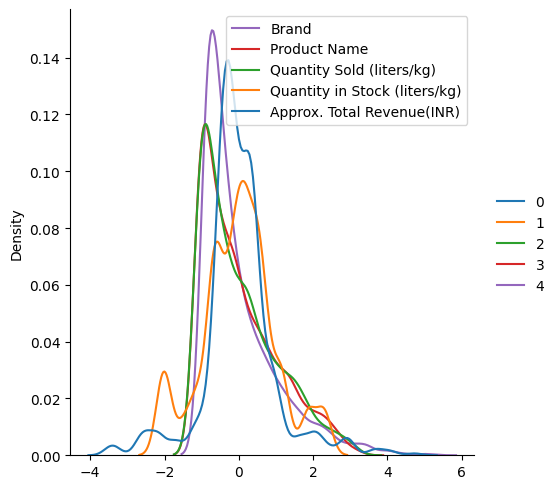

In [650]:
sns.displot(x_train_standard, kind="kde")
plt.legend(labels=["Brand","Product Name","Quantity Sold (liters/kg)", "Quantity in Stock (liters/kg)","Approx. Total Revenue(INR)"])
plt.show()

Min-Max Scaling

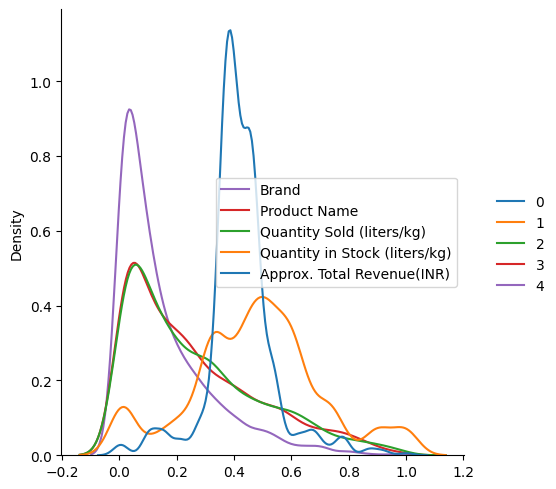

In [651]:
sns.displot(x_train_mm, kind="kde")
plt.legend(labels=["Brand","Product Name","Quantity Sold (liters/kg)", "Quantity in Stock (liters/kg)","Approx. Total Revenue(INR)"])
plt.show()

Robust Scaling

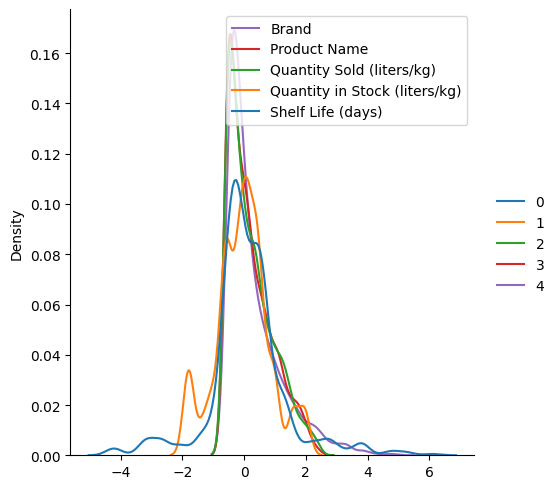

In [652]:
sns.displot(x_train_robust, kind="kde")
plt.legend(labels=["Brand", "Product Name", "Quantity Sold (liters/kg)", "Quantity in Stock (liters/kg)", "Shelf Life (days)"])
plt.show()

We can see that robust scaling has more "Normal" distribution but has a larger range compared to z-score standardization. While we can see a lot of right-skewed attirbutes from Min-Max scaling.

# Build Model

This is to demonstrate the resulting  of model made wisth data scaled by StandardScaler vs Robust Scalert scaler. The model will use KNeighboursRegressor since we're gonna predict numerical attribute with both categorical and numercial attributes as dependent vars.

In [653]:
def print_best_k_and_rmse(x_train, x_test, y_train, y_test) -> None:
    chosen_k = 9999
    lowest_rmse = 1e100
    for k in range(1,int(4326**0.5)+1):
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rsme = mse ** 0.5
        if rsme < lowest_rmse:
            chosen_k = k
            lowest_rmse = rsme
        if k == 7:
            print(k, rsme, mae)
    print(f"Best k:{chosen_k}\nRMSE of k={chosen_k}: {lowest_rmse}")

Standard Scaler

In [654]:
print_best_k_and_rmse(x_train_standard, x_test_standard, y_train, y_test)

7 8286.058024908763 5269.412986429672
Best k:4
RMSE of k=4: 8240.119847607826


Min-Max scaler

In [655]:
print_best_k_and_rmse(x_train_mm, x_test_mm, y_train, y_test)

7 8603.514792800668 5515.09338372221
Best k:7
RMSE of k=7: 8603.514792800668


Robust scaler

In [656]:
print_best_k_and_rmse(x_train_robust, x_test_robust, y_train, y_test)

7 8611.277078193427 5496.155663229144
Best k:4
RMSE of k=4: 8457.592694485871


From here, we can see that robust scaler have lower rmse than standard scaler when using the best k. The reason we only use k from 1 to sqrt of dataset rows is ....